In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   

In [2]:
# data transform
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'C:/Users/user/Desktop/fer2013_master/Dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

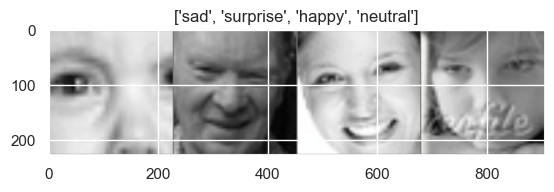

In [23]:
#show the image data
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  



inputs, classes = next(iter(dataloaders['train']))


out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(
        f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [3]:
model_ft = models.densenet121(weights='IMAGENET1K_V1')
num_ftrs = model_ft.classifier.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 7) #seven classes

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25) #model training

Epoch 0/24
----------
train Loss: 1.7864 Acc: 0.3108
val Loss: 2.8765 Acc: 0.4465

Epoch 1/24
----------
train Loss: 1.5401 Acc: 0.4129
val Loss: 1.2841 Acc: 0.5117

Epoch 2/24
----------
train Loss: 1.4154 Acc: 0.4569
val Loss: 1.1269 Acc: 0.5800

Epoch 3/24
----------
train Loss: 1.3482 Acc: 0.4846
val Loss: 1.2135 Acc: 0.5797

Epoch 4/24
----------
train Loss: 1.3132 Acc: 0.5018
val Loss: 1.1803 Acc: 0.5929

Epoch 5/24
----------
train Loss: 1.2718 Acc: 0.5144
val Loss: 1.2428 Acc: 0.5500

Epoch 6/24
----------
train Loss: 1.2486 Acc: 0.5239
val Loss: 1.0490 Acc: 0.6220

Epoch 7/24
----------
train Loss: 1.1300 Acc: 0.5704
val Loss: 0.9718 Acc: 0.6434

Epoch 8/24
----------
train Loss: 1.0979 Acc: 0.5838
val Loss: 0.9535 Acc: 0.6558

Epoch 9/24
----------
train Loss: 1.0865 Acc: 0.5902
val Loss: 0.9710 Acc: 0.6467

Epoch 10/24
----------
train Loss: 1.0816 Acc: 0.5910
val Loss: 0.9512 Acc: 0.6580

Epoch 11/24
----------
train Loss: 1.0668 Acc: 0.5966
val Loss: 0.9436 Acc: 0.6558

Ep

In [11]:
torch.save(model_ft.state_dict(), "C:/Users/user/Desktop/fer2013_master/model/dense.pt")

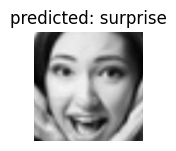

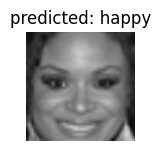

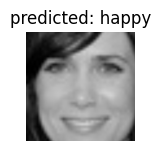

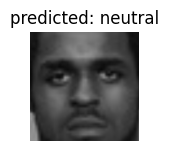

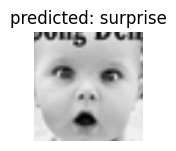

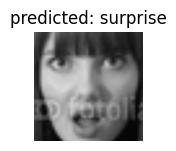

In [12]:
visualize_model(model_ft)

In [4]:
model_ft.load_state_dict(torch.load("C:/Users/user/Desktop/fer2013_master/model/dense.pt"))

<All keys matched successfully>

In [6]:
#FERPlus test
test_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_data = datasets.ImageFolder("C:/Users/user/Desktop/fer2013_master/test", transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 16, num_workers = 0)

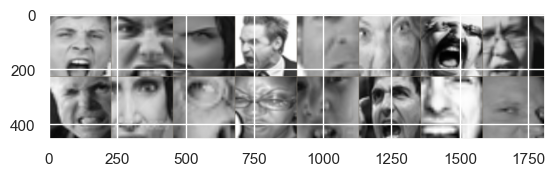

GroundTruth:  angry angry angry angry


In [29]:
classes_img = ('angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise')
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{str(classes_img[labels[j]]):5s}' for j in range(4)))


In [9]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model_ft(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the ferplus test images: {100 * correct // total} %')

Accuracy of the network on the ferplus test images: 49 %


Text(92.25, 0.5, 'True labels')

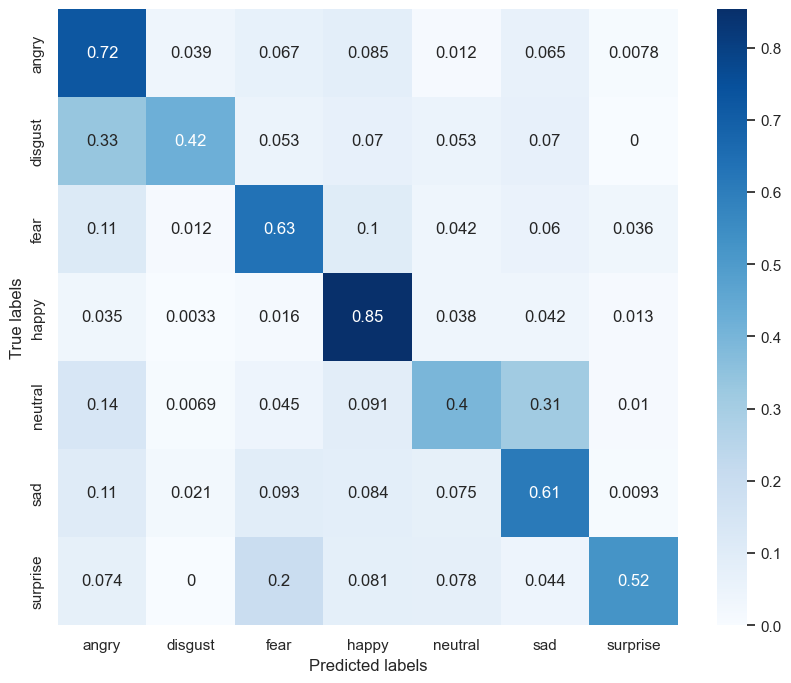

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
predicted_labels = []
true_labels = []
label_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
model_ft.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _,predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)
confusion = confusion_matrix(true_labels, predicted_labels)
normalized_matrix = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
sns.set()
plt.figure(figsize=(10, 8))
sns.heatmap(normalized_matrix, annot=True, cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")

    

In [18]:
#test_transform for facial expression recognition 
test_facial_data = datasets.ImageFolder("C:/Users/user/Desktop/fer2013_master/validation", transform=test_transform)
facial_loader = torch.utils.data.DataLoader(test_facial_data, batch_size = 16, num_workers = 0)

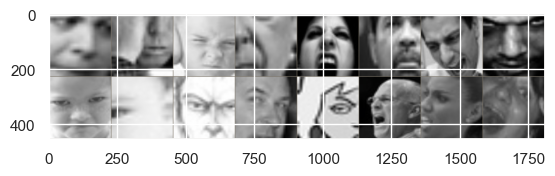

GroundTruth:  angry angry angry angry


In [31]:
dataiter = iter(facial_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{str(classes_img[labels[j]]):5s}' for j in range(4)))

In [20]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in facial_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model_ft(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the facial expression test images: {100 * correct // total} %')


Accuracy of the network on the facial expression test images: 61 %


Text(92.25, 0.5, 'True labels')

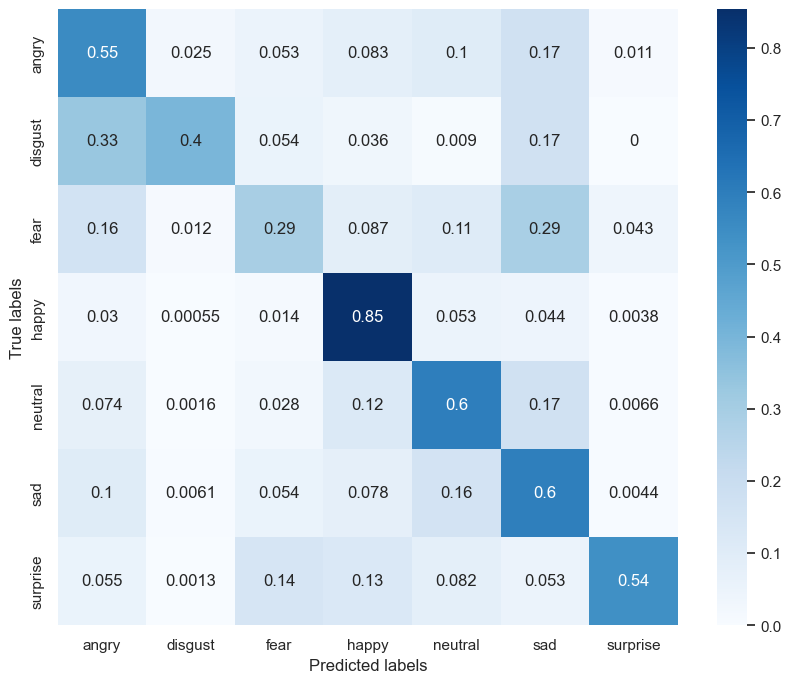

In [21]:
#facial expression
from sklearn.metrics import confusion_matrix
import seaborn as sns
predicted_labels = []
true_labels = []
label_names = ['angry', 'disgust', 'fear','happy', 'neutral', 'sad', 'surprise']
model_ft.eval()
with torch.no_grad():
    for images, labels in facial_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)
confusion = confusion_matrix(true_labels, predicted_labels)
normalized_matrix = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
sns.set()
plt.figure(figsize=(10, 8))
sns.heatmap(normalized_matrix, annot=True, cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
